In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../python')
import os
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as tt
import torch.backends.cudnn as cudnn
import torch.nn as nn


import pickle

from tqdm import tqdm

# from torchinfo import summary



from models import * #ResNet18
from functions import *
from Optimizers import PAdam

import time


import matplotlib.pyplot as plt
import numpy as np

# from functions import *


In [3]:


device=torch.device('mps')




model=to_device(resnet18(10),device)

model.append_small_weight_vec(0.1,0)
model.append_small_weight_vec(0.3,1)
model.sparsity_df

Number of trainable parameters: 11,173,962, grouped into:
21 decayed parameter tensors, with 11,164,352 parameters
41 non-decayed parameter tensors, with 9,610 parameters


,Layer,Sublayer,Component,paramsCount,SmallWeights_epoch0,SmallWeights_epoch1
0,conv1,,Conv2d,1728,902,1728
1,layer1,0.conv1,Conv2d,36864,36864,36864
2,layer1,0.conv2,Conv2d,36864,36864,36864
3,layer1,1.conv1,Conv2d,36864,36864,36864
4,layer1,1.conv2,Conv2d,36864,36864,36864
5,layer2,0.conv1,Conv2d,73728,73728,73728
6,layer2,0.conv2,Conv2d,147456,147456,147456
7,layer2,0.shortcut.0,Conv2d,8192,6548,8192
8,layer2,1.conv1,Conv2d,147456,147456,147456
9,layer2,1.conv2,Conv2d,147456,147456,147456


In [91]:
device=torch.device('mps')
model=to_device(ResNet18(3,10),device)

model.append_small_weight_vec(0.1,0)
model.sparsity_df

Number of trainable parameters: 12,557,898, grouped into:
21 decayed parameter tensors, with 12,548,288 parameters
41 non-decayed parameter tensors, with 9,610 parameters


,Layer,Sublayer,Component,paramsCount,SmallWeights_epoch0
0,conv1,0,Conv2d,9408,5748
1,res1,0.0,Conv2d,36864,33602
2,res1,1.0,Conv2d,36864,33524
3,res2,0.0,Conv2d,36864,33630
4,res2,1.0,Conv2d,36864,33481
5,downsample1,0,Conv2d,73728,67082
6,res3,0.0,Conv2d,73728,67066
7,res3,1.0,Conv2d,147456,145031
8,res4,0.0,Conv2d,147456,145012
9,res4,1.0,Conv2d,147456,145145


In [93]:
model.decayed_weights_histogram()


(array([ 0.30103  , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       ,  0.69897  ,
         1.       ,  1.0791812,  1.2787536,  1.5797836,  1.7993406,
         1.9912261,  2.292256 ,  2.563481 ,  2.7641761,  3.0831442,
         3.3300078,  3.6002102,  3.8406706,  4.1039405,  4.36838  ,
         4.6198964,  4.883264 ,  5.1437798,  5.402306 ,  5.6621976,
         5.9178934,  6.1661587,  6.386779 ,  6.5204654,  6.422084 ,
         5.8817964,  4.871894 ,  3.4539297,  1.9956352, -1.       ],
       dtype=float32),
 array([-13.       , -12.74     , -12.48     , -12.22     , -11.96     ,
        -11.7      , -11.440001 , -11.18     , -10.92     , -10.66     ,
        -10.4      , -10.14     ,  -9.88     ,  -9.62     ,  -9.360001 ,
         -9.1      ,  -8.84     ,  -8.58     ,  -8.32     ,  -8.06     ,
    

In [7]:
# def calculate_gradients_efficiently(model, input_data, target, criterion):
#     grad_magnitudes = {}

#     # Initially set requires_grad to False for all parameters
#     for _, param, _ in model.decay_params:
#         param.requires_grad = False

#     # Iterate through each parameter and calculate its gradient
#     for group_name, param, _ in model.decay_params:
#         print(f"Calculating gradients for group {group_name}...")
#         # Enable gradient computation for the current parameter
#         param.requires_grad = True

#         # Forward pass
#         output = model(input_data)
#         loss = criterion(output, target)

#         # Backward pass
#         model.zero_grad()
#         loss.backward()

#         # Store the gradient magnitude
#         grad_magnitudes[group_name] = param.grad.data.norm().item()

#         # Disable gradient computation before moving to the next parameter
#         param.requires_grad = False

#     return grad_magnitudes

def calculate_gradients_efficiently(model, input_data, target, criterion):
    grad_magnitudes = {}

    # Initially set requires_grad to False for all parameters
    for _, param, _ in model.decay_params:
        param.requires_grad = False

    # Iterate through each parameter and calculate its gradient
    for group_name, param, _ in model.decay_params:
        print(f"Calculating gradients for group {group_name}...")
        
        # Construct a unique identifier for each parameter
        param_name = f"{group_name}.{param.shape}"

        # Enable gradient computation for the current parameter
        param.requires_grad = True

        # Forward pass
        output = model(input_data)
        loss = criterion(output, target)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Store the gradient magnitude
        grad_magnitudes[param_name] = param.grad.data.norm().item()

        # Disable gradient computation before moving to the next parameter
        param.requires_grad = False

    return grad_magnitudes



# Example usage
import torchvision
import torchvision.transforms as transforms

# Load and preprocess CIFAR10 data
transform = transforms.Compose([
    transforms.Resize(224),  # Resizing images to fit ResNet18 input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=4, shuffle=True)

# Initialize the modified ResNet18 model
model = ResNet18(3, 10)  # Adjust the constructor as per your definition
# model._initialize_param_groups()

# Define the criterion
criterion = torch.nn.CrossEntropyLoss()


# Calculate gradients for a single batch of CIFAR10 data
data_iter = iter(cifar10_trainloader)
images, labels = next(data_iter)

grad_magnitudes_decayed = calculate_gradients_efficiently(model, images, labels, criterion)


Files already downloaded and verified
Number of trainable parameters: 12,557,898, grouped into:
21 decayed parameter tensors, with 12,548,288 parameters
41 non-decayed parameter tensors, with 9,610 parameters
Calculating gradients for group conv1.0...
Calculating gradients for group res1.0.0...
Calculating gradients for group res1.1.0...
Calculating gradients for group res2.0.0...
Calculating gradients for group res2.1.0...
Calculating gradients for group downsample1.0...
Calculating gradients for group res3.0.0...
Calculating gradients for group res3.1.0...
Calculating gradients for group res4.0.0...
Calculating gradients for group res4.1.0...
Calculating gradients for group res5.0.0...
Calculating gradients for group res5.1.0...
Calculating gradients for group downsample2.0...
Calculating gradients for group res6.0.0...
Calculating gradients for group res6.1.0...
Calculating gradients for group res7.0.0...
Calculating gradients for group res7.1.0...
Calculating gradients for group do

In [12]:
# grad_magnitudes_decayed
for group_name, param, _ in model.decay_params:
    print(param)


Parameter containing:
tensor([[[[ 1.2598e-02, -3.0337e-01, -2.3935e-01,  ..., -8.8650e-02,
            1.9137e-01, -1.7609e-01],
          [ 1.5710e-01,  1.6960e-01, -8.2780e-02,  ..., -1.1106e-01,
           -1.0462e-01, -1.5225e-01],
          [-5.1064e-02,  5.2390e-02, -7.1839e-03,  ...,  1.1935e-01,
            1.9717e-01,  1.2517e-01],
          ...,
          [-1.0571e-01,  1.8559e-01,  1.0988e-01,  ...,  5.8345e-02,
           -1.4681e-02, -5.1220e-02],
          [-1.7489e-01,  2.2153e-01,  1.2694e-01,  ..., -3.6696e-02,
            1.0093e-01, -5.4157e-02],
          [ 1.6053e-01, -2.0015e-01, -9.5406e-02,  ..., -2.4348e-01,
            2.6793e-01,  2.1027e-02]],

         [[-1.4315e-02,  4.8499e-02, -2.3672e-02,  ..., -1.4326e-01,
           -7.2566e-02, -2.1290e-01],
          [-8.7179e-03,  1.1577e-02,  1.3831e-02,  ...,  1.5577e-01,
            1.0732e-01,  2.4892e-02],
          [ 8.6481e-02, -5.4293e-02,  1.4457e-01,  ..., -7.7767e-03,
            1.2474e-02, -1.6900e-01]

In [2]:
# load device and model

device = get_default_device()
device=torch.device('cuda:3')
print(f'Device used: {device}')

model=to_device(ResNet18(3, 10), device)

num_params=sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params:,}")

device=torch.device('cuda:3')

Device used: cuda:3
Number of trainable parameters: 12,562,698


In [3]:
# define transformation/augmentation
data_path = '../data'
mean_std_file = os.path.join(data_path, 'cifar10_mean_std.pkl')


# Check if mean/std file exists, calculate if not
if not os.path.exists(mean_std_file):
    # Load CIFAR-10 without normalization
    trainset_raw = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=tt.ToTensor())
    mean, std = calculate_mean_std(trainset_raw)
    with open(mean_std_file, 'wb') as f:
        pickle.dump((mean, std), f)
    print("Mean and Std Dev calculated and saved.")
else:
    with open(mean_std_file, 'rb') as f:
        mean, std = pickle.load(f)
    print("Mean and Std Dev loaded from file.")

print(f"Mean: {mean}, Std: {std}")

transform_train = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 

                         tt.RandomRotation(degrees=(-10, 10)),
                         tt.RandomHorizontalFlip(), 
                         #tt.RandomPerspective(distortion_scale=0.14),
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                         tt.ToTensor(), 
                         tt.Normalize(mean,std,inplace=True)])
transform_test = tt.Compose([tt.ToTensor(), tt.Normalize(mean, std)])

Mean and Std Dev loaded from file.
Mean: tensor([0.4915, 0.4822, 0.4466]), Std: tensor([0.2463, 0.2428, 0.2607])


In [4]:
batch_size=400

# Load the CIFAR-10 dataset with transforms above
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3,pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=2*batch_size, shuffle=False, num_workers=3,pin_memory=True)


# move to device
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
epochs = 50
max_lr = 0.001
grad_clip = 0.75
weight_decay = 0.0001
betas=(0.9,0.99)

In [6]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr,weight_decay=weight_decay,fused=True, betas=betas)
optimizer = PAdam(model.parameters(), lr=max_lr, lambda_p=5e-4, p_norm=0.8, betas=betas, fused=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
#                                         T_0 = 1563,# Number of iterations for the first restart (Total iterations are epochs*len(train_loader) then divide that by how many times you want a restart)
#                                         T_mult = 1, # A factor increases TiTi​ after a restart
#                                         eta_min = 1e-5) # Minimum learning rate
lr_int=5e-5
lr_fin=5e-5
div_factor=max_lr/lr_int
final_div_factor=lr_int/lr_fin
scheduler = torch.optim.lr_scheduler.OneCycleLR(
                                                optimizer, 
                                                max_lr, 
                                                epochs=epochs,
                                                steps_per_epoch=len(trainloader), 
                                                pct_start=0.1,
#                                                 div_factor=div_factor,
                                                final_div_factor=1e4
                                            )


# Visualize scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
                                                optimizer, 
                                                max_lr, 
                                                epochs=epochs,
                                                steps_per_epoch=len(trainloader), 
                                                pct_start=0.1,
                                                div_factor=div_factor,
                                                final_div_factor=final_div_factor
                                            )
l_t=len(trainloader)
lrs=[]
for epoch in range(epochs):
        for d in range(l_t):
            lrs.append(optimizer.param_groups[0]['lr'])
            scheduler.step()
            

print(lrs[0],lrs[-1],max(lrs))
plt.semilogy(lrs)
plt.show()

In [7]:
# model = torch.compile(model) # requires PyTorch 2.0



best_accuracy = 0.0
iteration_count = 0
train_losses = []
val_losses = []
accuracies = []
lrs = []

start_time = time.time()    
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for data in trainloader:
        iteration_count += 1
        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        running_loss += loss.item()
        scheduler.step()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    running_val_loss = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            



    avg_val_loss = running_val_loss / len(testloader)
    val_losses.append(avg_val_loss)

    accuracy = 100 * correct / total
    accuracies.append(accuracy)

    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': accuracy,
        }, '../data/best_model.pth')

    # Calculate and format runtime and expected time
    elapsed_time = time.time() - start_time
    expected_time = elapsed_time * epochs / (epoch + 1)
    elapsed_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    expected_str = time.strftime("%H:%M:%S", time.gmtime(expected_time))

    # Track and store current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)

    status_message = f"Epoch: {epoch+1}/{epochs}\titer: {iteration_count}\tTrain Loss: {avg_train_loss:.4f}\tTest Loss: {avg_val_loss:.4f}\tAccuracy: {accuracy:.2f}%\tCurrent LR: {current_lr:.5f}\tElapsed Time: {elapsed_str}\tExpected Time: {expected_str}"
    print(f"\r{status_message}",end='')

print()
print('Finished Training')

Epoch: 50/50	iter: 6250	Train Loss: 0.0316	Test Loss: 0.2540	Accuracy: 93.26%	Current LR: 0.00000	Elapsed Time: 00:35:28	Expected Time: 00:35:28
Finished Training


[autoreload of urllib3.exceptions failed: Traceback (most recent call last):
  File "/global/home/users/njo/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/global/home/users/njo/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/global/home/users/njo/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/global/home/users/njo/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/global/home/users/njo/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/global/home/users/njo/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 26

4.077981745494369e-09


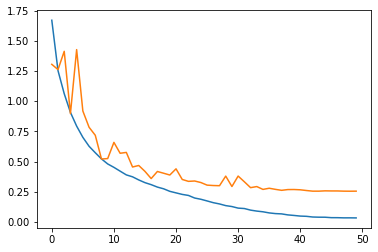

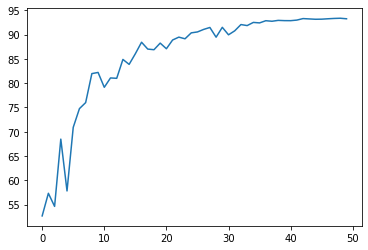

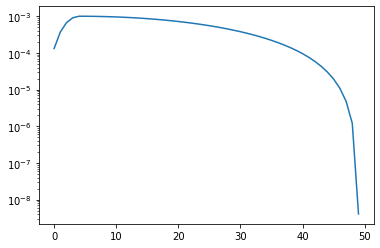

In [8]:

print(lrs[-1])

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

plt.plot(accuracies)
plt.show()

plt.semilogy(lrs)
plt.show()


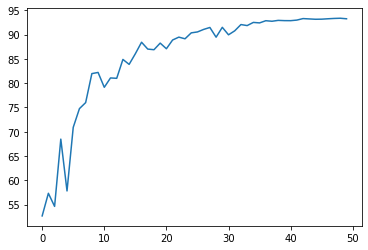

In [9]:
plt.plot(accuracies)
plt.show()

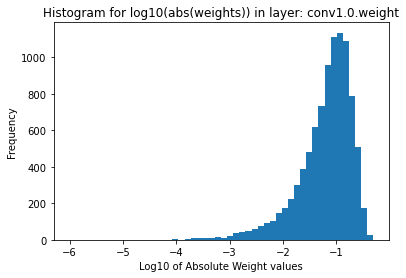

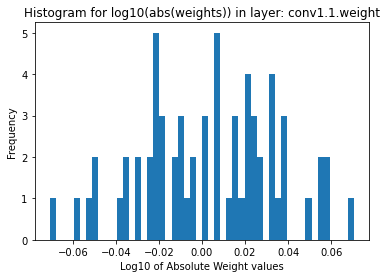

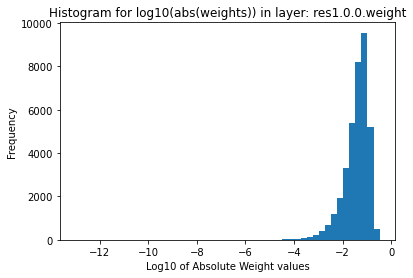

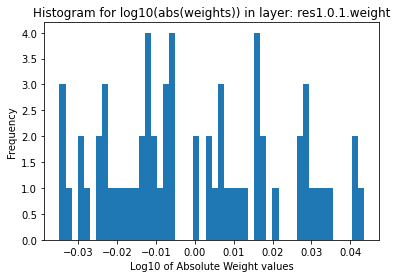

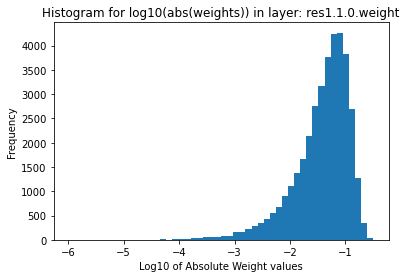

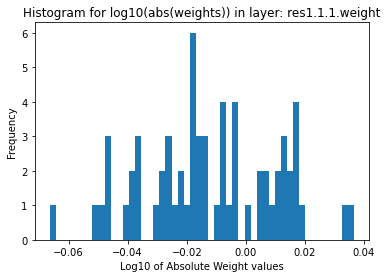

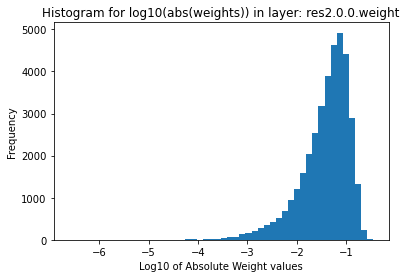

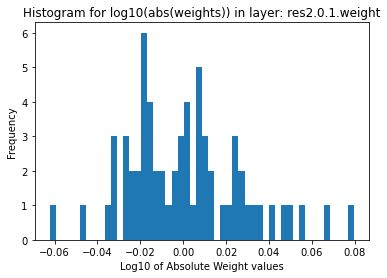

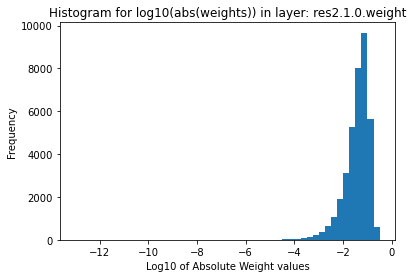

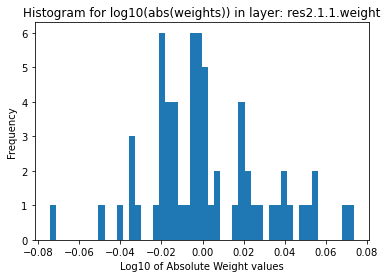

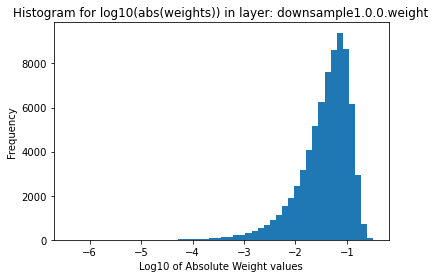

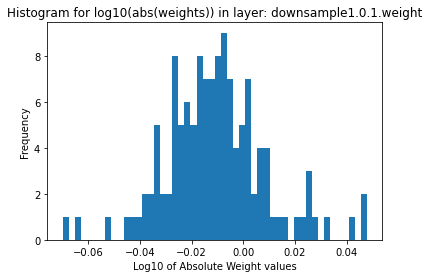

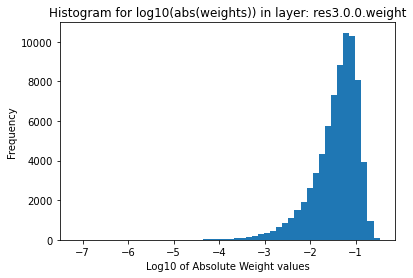

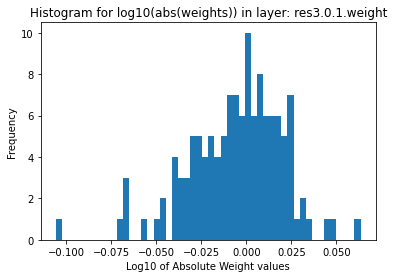

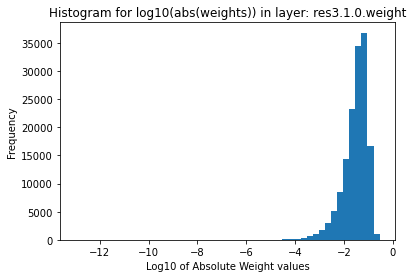

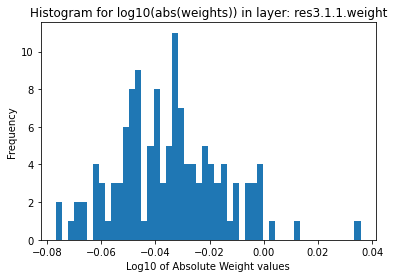

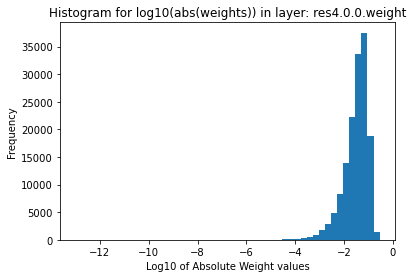

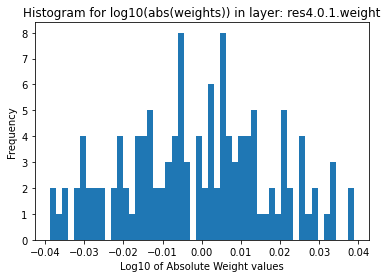

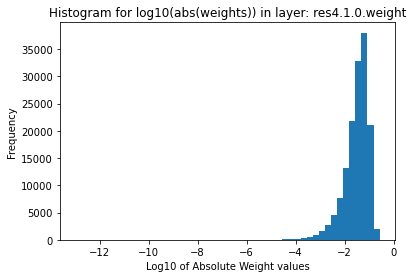

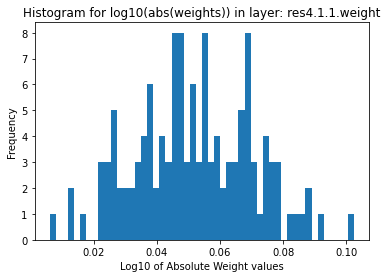

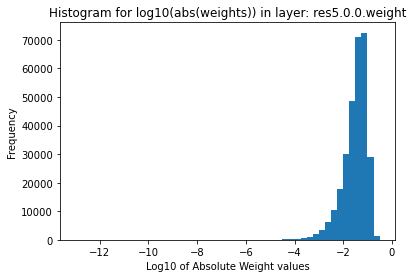

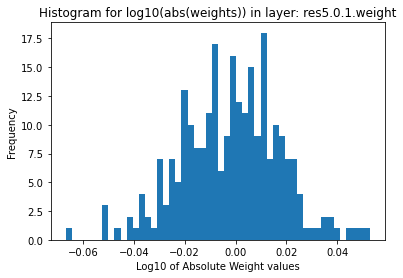

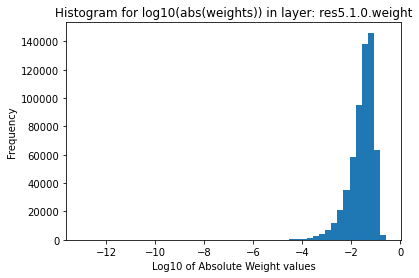

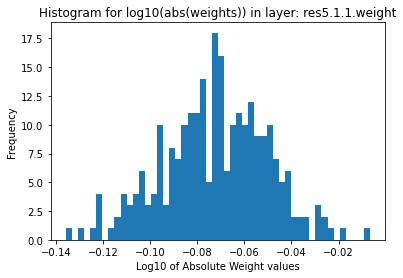

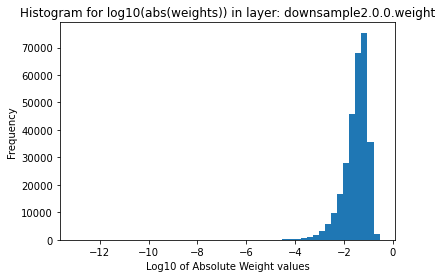

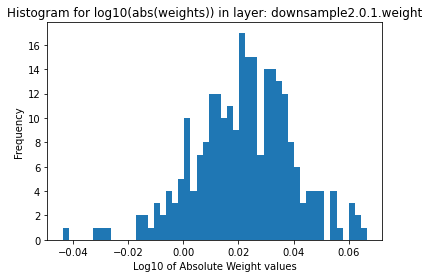

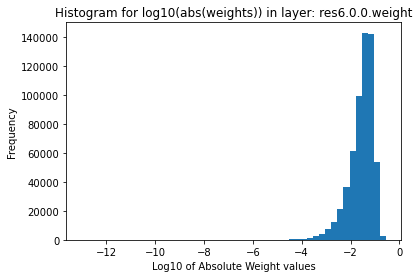

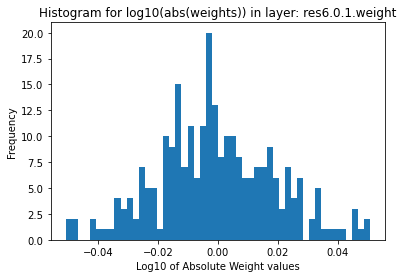

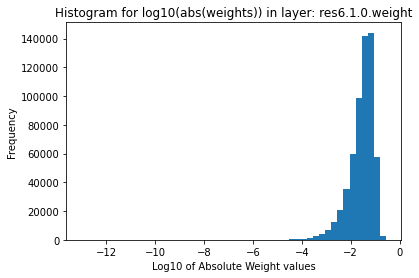

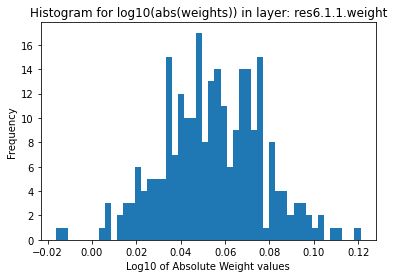

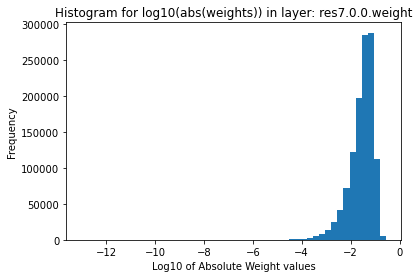

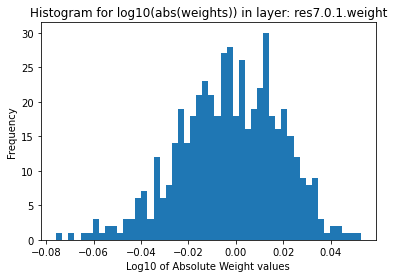

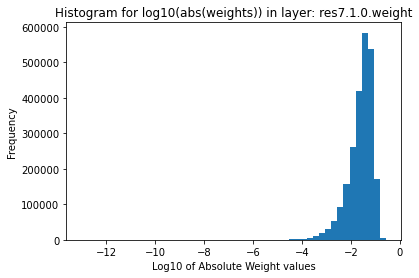

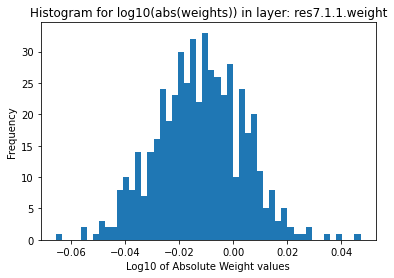

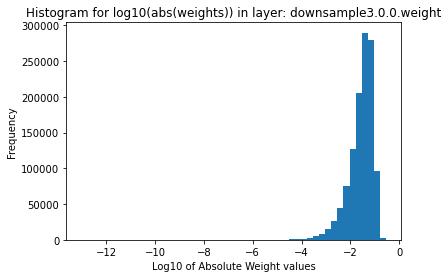

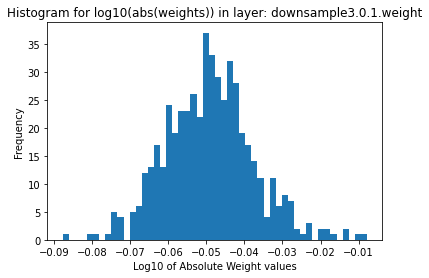

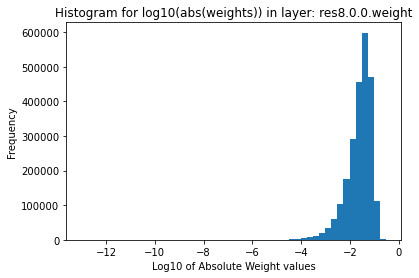

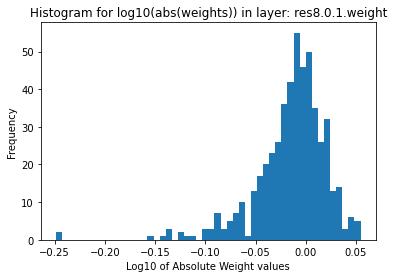

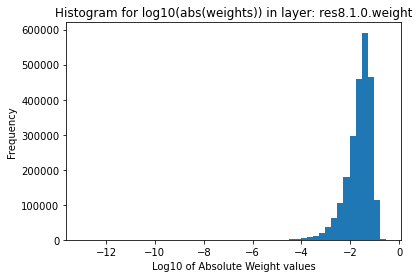

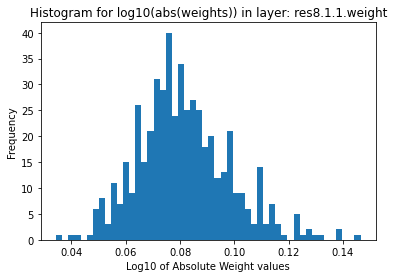

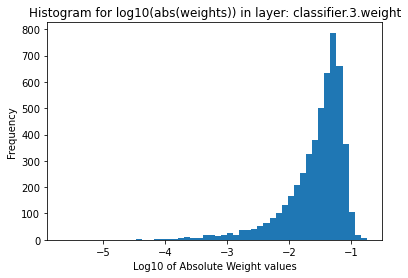

3.024827946990368e-05

In [10]:
# Load the saved model
checkpoint = torch.load('../data/best_model.pth')
model_state_dict = checkpoint['model_state_dict']

# Iterate over each layer in the model
zeros=0
for layer_name, weights in model_state_dict.items():
    # Ensure you're looking at layer weights, not biases
    if "weight" in layer_name:
        # Convert the weights to a numpy array
        weights = weights.cpu().numpy()

        # Apply log10 to the absolute values of weights, with a small offset to avoid log(0)
        log_weights = np.log10(np.abs(weights) + 1e-13)
        zeros+=np.sum(log_weights<-12.5)
        

        # Plot histogram
        plt.hist(log_weights.reshape(-1), bins=50)
        plt.title(f"Histogram for log10(abs(weights)) in layer: {layer_name}")
        plt.xlabel("Log10 of Absolute Weight values")
        plt.ylabel("Frequency")
        plt.show()
        
zeros/num_params


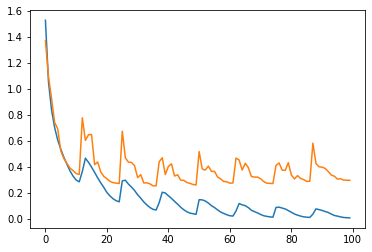

In [8]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os


history_df = pd.read_pickle("../results/CIFAR10/all_runs_history.pkl")
metadata_df = pd.read_pickle("../results/CIFAR10/all_runs_metadata.pkl")




# Merge on run_id
combined_df = pd.merge(history_df, metadata_df, on="run_id")




# # show df fields
# metadata_df.columns, history_df.columns

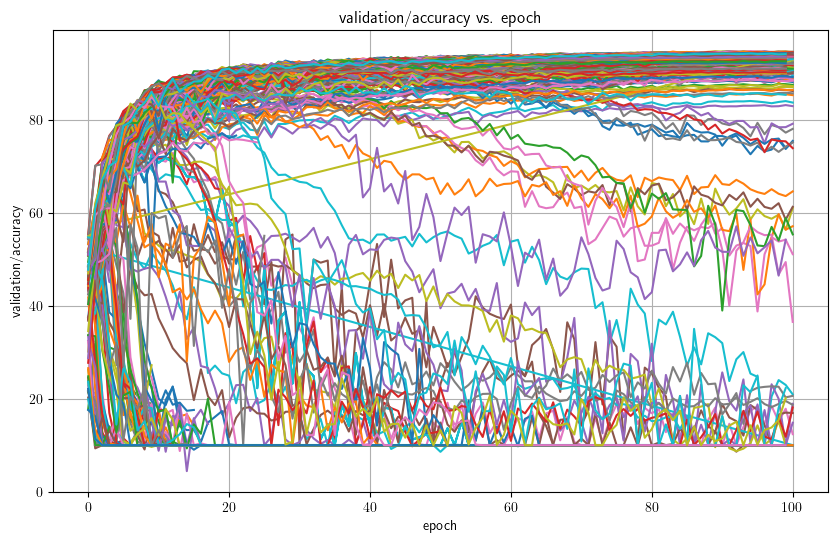

In [ ]:
df_100=combined_df[combined_df['epochs']==100]

def plot_xy(data, x_column, y_column):
    plt.figure(figsize=(10, 6))

    for run_id in data['run_id'].unique():
        run_data = data[data['run_id'] == run_id]
        plt.plot(run_data[x_column], run_data[y_column], label=f'Run {run_id}')

    plt.title(f'{y_column} vs. {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    # plt.legend()
    plt.grid(True)
    plt.show()


plot_xy(df_100, 'epoch', 'validation/accuracy')


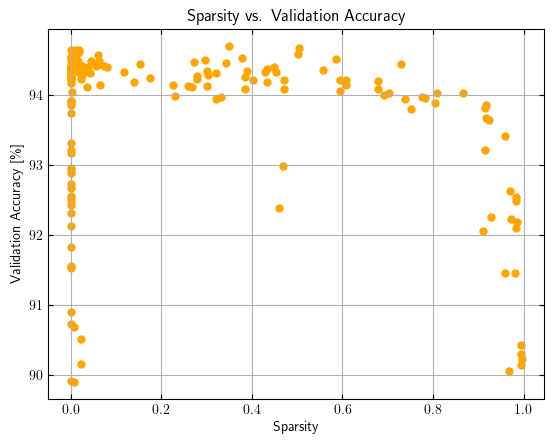

In [ ]:
# activate latex text rendering
plt.rc('text', usetex=True)
# Create a color map for different runs
colors = plt.cm.tab10.colors

# Iterate over each run_id
for i, (run_id, group) in enumerate(grouped_df):
    # Find the index with the maximum validation/best_accuracy
    ind = np.argmax(group['validation/best_accuracy'])

    # Get the corresponding sparsity and validation/best_accuracy values at that index
    sparsity = group['sparsity'].values[ind]
    accuracy = group['validation/best_accuracy'].values[ind]

    # Plot the data with different colors for each run
    plt.scatter(sparsity, accuracy, label=f'Run {run_id}', color='orange', marker='.', s=100)

# Set the x and y labels
plt.xlabel('Sparsity')
plt.ylabel('Validation Accuracy [\%]')

# Add a title
plt.title('Sparsity vs. Validation Accuracy')

# Add a grid
plt.grid(True)

# Show ticks on both sides of both axes, directed inward
plt.tick_params(axis='both', direction='in', top=True, right=True)


# Show the plot
plt.show()


In [ ]:
df_100.columns